In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('datasets/Train.csv')

# ignore columns call_type	call_status	start_time	duration	end_time	display_location

df = df.drop(columns=['call_type', 'call_status', 'start_time', 'duration', 'end_time', 'display_location'])
df['conversions_calls'] = df['conversions_calls'].interpolate().fillna(df['conversions_calls'].interpolate().mean())


# Step 1: Identify numeric columns
numeric_columns = df.select_dtypes(include=['float64']).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())
df = df.dropna()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 289526 entries, 0 to 289525
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   impressions         289526 non-null  float64
 1   clicks              289526 non-null  float64
 2   cost                289526 non-null  float64
 3   conversions         289526 non-null  float64
 4   ad_type             289526 non-null  object 
 5   currency            289526 non-null  object 
 6   ID                  289526 non-null  object 
 7   date                289526 non-null  object 
 8   impression_share    289526 non-null  float64
 9   conversions_calls   289526 non-null  float64
 10  headline1_len       289526 non-null  float64
 11  headline2_len       289526 non-null  float64
 12  ad_description_len  289526 non-null  float64
dtypes: float64(9), object(4)
memory usage: 30.9+ MB


In [4]:
df['currency'].unique(), df['currency'].nunique()

(array(['ZAR', 'USD'], dtype=object), 2)

In [5]:
# Example exchange rates for ZAR and USD
exchange_rates = {'USD': 1.0, 'ZAR': 0.071}  # 1 USD = 0.071 ZAR

# Function to convert cost to USD
def convert_to_usd(currency, cost):
    exchange_rate = exchange_rates.get(currency, 1.0)  # Default to 1.0 if currency not found
    return cost * exchange_rate

# Update 'cost' column with cost in USD
df['cost'] = df.apply(lambda row: convert_to_usd(row['currency'], row['cost']), axis=1)

# leaving currency column to determine locality


In [6]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

In [7]:
# display rows with ID ID_5e43c29e6279884e2827d894

df.loc[df['ID'] == 'ID_5e43c29e6279884e2827d894']['ad_type'].unique()

array(['EXPANDED_TEXT_AD', 'EXPANDED_DYNAMIC_SEARCH_AD'], dtype=object)

In [8]:
# one hot encode currency and ad_type

df = pd.get_dummies(df, columns=['currency', 'ad_type'])

In [9]:
y = df['clicks']
X = df.drop(columns=['ID', 'clicks'])

X = X.drop(['date'], axis=1)

In [10]:
from sklearn.preprocessing import StandardScaler

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

In [11]:
_prepd_df = pd.concat([X, y], axis=1)

<Axes: >

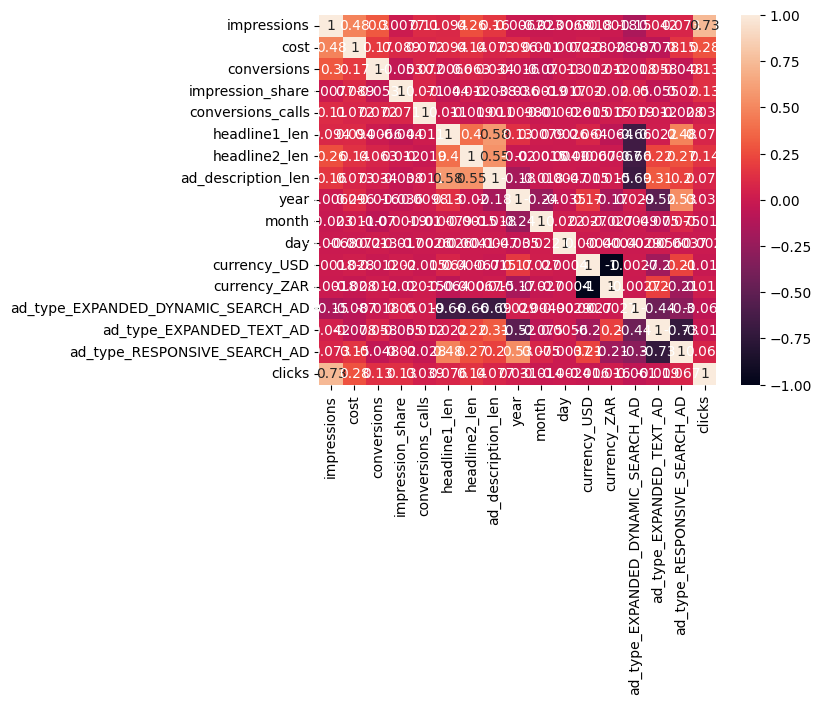

In [12]:
# plot correlation matrix
import seaborn as sns

corr = _prepd_df.corr()

sns.heatmap(corr, annot=True)

In [13]:
# from corr matrix, show features correlation with clicks

corr['clicks'].sort_values(ascending=False)


clicks                                1.000000
impressions                           0.734686
cost                                  0.278523
headline2_len                         0.144910
conversions                           0.128776
impression_share                      0.126332
ad_description_len                    0.077180
headline1_len                         0.075684
ad_type_RESPONSIVE_SEARCH_AD          0.066658
conversions_calls                     0.038814
year                                  0.030796
currency_ZAR                          0.016201
day                                  -0.002419
month                                -0.014417
currency_USD                         -0.016201
ad_type_EXPANDED_TEXT_AD             -0.019154
ad_type_EXPANDED_DYNAMIC_SEARCH_AD   -0.060715
Name: clicks, dtype: float64

In [14]:
# using the features with correlation > 0.1 from corr['clicks']

corr_features = corr['clicks'][corr['clicks'] > 0].index.drop('clicks')

In [15]:
%%capture
x = X[corr_features]
# y = df['clicks']

# # add date features for time series
x['year'] = X['year']
x['month'] = X['month']
x['day'] = X['day']

In [16]:
x.head()

,impressions,cost,conversions,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,year,currency_ZAR,ad_type_RESPONSIVE_SEARCH_AD,month,day
0,0.450480,0.136493,-0.076726,-0.032266,-0.239826,-0.47456,1.269298,0.065160,-2.43374,0.233002,-0.709693,-1.602911,-1.667347
1,0.105411,-0.072893,-0.076726,-0.032266,-0.239826,-0.47456,-0.526729,0.508674,-2.43374,0.233002,-0.709693,-1.602911,-1.667347
2,-0.089911,-0.082724,-0.076726,-0.032266,-0.239826,-0.47456,-0.526729,-0.156597,-2.43374,0.233002,-0.709693,-1.602911,-1.667347
3,0.033793,-0.192465,-0.076726,-0.032266,-0.239826,-0.47456,0.071946,0.508674,-2.43374,0.233002,-0.709693,-1.602911,-1.667347
4,-0.343829,-0.285467,-0.076726,-0.032266,-0.239826,-0.47456,-0.526729,0.508674,-2.43374,0.233002,-0.709693,-1.602911,-1.667347


In [17]:
# length check
len(x) == len(y)

True

In [18]:
# train test split
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# models

In [20]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, BayesianRidge
# from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Initialize and train models
models = {
    # "XGBoost": xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.1, max_depth=3),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    # "LinearRegression": LinearRegression(),
    # "ElasticNet": ElasticNet(),
    # "BayesianRidge": BayesianRidge(),
    # "KNeighborsRegressor": KNeighborsRegressor(),
    # "DecisionTreeRegressor": DecisionTreeRegressor(),
    # "MLPRegressor": MLPRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print("Trainig ", name)
    try:
        model.fit(x_train, y_train)
        predictions = model.predict(x_test)
        mse = mean_squared_error(y_test, predictions)
        results[name] = mse
    except Exception as e:
        print(f"Error occurred while training {name}: {e}")
        results[name] = None  # Set MSE to None if an error occurs



# Print results
for name, mse in results.items():
    if mse is not None:
        rmse = sqrt(mse)
        print(f"{name} |--| Mean Squared Error: {mse}, |--| Root Mean Squared Error: {rmse}")
    else:
        print(f"{name} failed to train.")



Trainig  RandomForest
RandomForest |--| Mean Squared Error: 22.87558464580527, |--| Root Mean Squared Error: 4.782842736888311


# neural Net

In [ ]:
# %%capture
# !pip install tensorflow

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import Dropout

In [ ]:
model = Sequential([
    Dense(64, activation='relu',input_shape=(x_train.shape[1], )),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')


In [ ]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_split=0.2, verbose=1, callbacks=early_stop)

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# Submision file Generation / inference


In [21]:
model_choice = "RandomForest"
model = models[model_choice]

In [23]:
# model evaluation
from sklearn.metrics import mean_squared_error

# Evaluate model
y_pred = model.predict(x_test)
y_pred = y_pred.flatten()

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'RMSE: {rmse}')
print(f'MSE: {mse}')

RMSE: 4.782842736888311
MSE: 22.87558464580527


In [24]:
def extract_id_and_date(string):
    parts = string.split('_')
    id_str = parts[1]
    date_str = '_'.join(parts[2:])
    return "ID_" + id_str, pd.to_datetime(date_str, format='%Y_%m_%d')


In [25]:
# submission file
test_df = pd.read_csv('datasets/SampleSubmission.csv')

In [26]:
test_df['id'], test_df['date'] = zip(*test_df['ID'].map(extract_id_and_date))
test_df['end_date'] = test_df['date'] + pd.Timedelta(days=20)

In [27]:
test_df.head()

,ID,clicks,id,date,end_date
0,ID_5da86e71bf5dee4cf5047046_2024_01_22,0,ID_5da86e71bf5dee4cf5047046,2024-01-22,2024-02-11
1,ID_5da86e71bf5dee4cf5047046_2024_01_29,0,ID_5da86e71bf5dee4cf5047046,2024-01-29,2024-02-18
2,ID_5e43c29e6279884e2827d894_2024_02_21,0,ID_5e43c29e6279884e2827d894,2024-02-21,2024-03-12
3,ID_5e43c29e6279884e2827d894_2024_02_28,0,ID_5e43c29e6279884e2827d894,2024-02-28,2024-03-19
4,ID_5e4e7b480e374330ee151305_2023_12_04,0,ID_5e4e7b480e374330ee151305,2023-12-04,2023-12-24


In [28]:
test_row = test_df.iloc[0]
test_row['id']

'ID_5da86e71bf5dee4cf5047046'

In [29]:

XX = X.copy()

In [30]:
XX['date'] = pd.to_datetime(df['date'])

In [31]:
XX['ID'] = df['ID']

In [32]:
XX.head(3)


,impressions,cost,conversions,impression_share,conversions_calls,headline1_len,headline2_len,ad_description_len,year,month,day,currency_USD,currency_ZAR,ad_type_EXPANDED_DYNAMIC_SEARCH_AD,ad_type_EXPANDED_TEXT_AD,ad_type_RESPONSIVE_SEARCH_AD,date,ID
0,0.450480,0.136493,-0.076726,-0.032266,-0.239826,-0.47456,1.269298,0.065160,-2.43374,-1.602911,-1.667347,-0.233002,0.233002,-0.425844,0.977188,-0.709693,2020-01-01,ID_5da86e71bf5dee4cf5047046
1,0.105411,-0.072893,-0.076726,-0.032266,-0.239826,-0.47456,-0.526729,0.508674,-2.43374,-1.602911,-1.667347,-0.233002,0.233002,-0.425844,0.977188,-0.709693,2020-01-01,ID_5da86e71bf5dee4cf5047046
2,-0.089911,-0.082724,-0.076726,-0.032266,-0.239826,-0.47456,-0.526729,-0.156597,-2.43374,-1.602911,-1.667347,-0.233002,0.233002,-0.425844,0.977188,-0.709693,2020-01-01,ID_5da86e71bf5dee4cf5047046


In [ ]:
def filter_df_by_id_or_date_range(df, id, start_date, end_date, sample=False):
    """
    Filter DataFrame by ID or date range.

    Args:
    df (DataFrame): Input DataFrame to filter.
    id (str): ID to filter.
    start_date (str or Timestamp): Start date of the range.
    end_date (str or Timestamp): End date of the range.

    Returns:
    DataFrame: Filtered DataFrame containing rows within the specified ID or date range.
    """
    filtered = df[(( df['ID'].str.contains('id') ) & (df['date'] >= start_date)) | ((df['ID'] == id) & (df['date'] <= end_date))]
    if sample: return filtered
    return filtered[x.columns]

In [ ]:
# Iterate over each row in test_df
for index, test_row in test_df.iterrows():
    # Filter rows in XX based on the ID or date range from the current row
    filtered_df = filter_df_by_id_or_date_range(XX, test_row['id'], test_row['date'], test_row['end_date'])

    # Predict clicks for the filtered data
    clicks_predict = model.predict(filtered_df)
    clicks_predict = clicks_predict.flatten() + rmse
    # Calculate sum of clicks and update the 'clicks' column in test_df
    test_df.at[index, 'clicks'] = int(np.mean(clicks_predict))



In [ ]:
filtered_df.head()

In [ ]:
# count clicks with 0s
test_df[test_df['clicks'] == 0].shape[0]

In [ ]:
test_df.head()

In [ ]:
test_df.to_csv("100ep_nn_attempt.csv", index=False)